In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
import subprocess
import sys
# for uninstalled packages, use:
def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

In [9]:
# load additional libraries

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

from itertools import product

import time

import xgboost
from xgboost import XGBRegressor
from xgboost import plot_importance

from lightgbm import LGBMRegressor
import lightgbm

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.model_selection import GridSearchCV

import pickle

from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial

In [10]:
## Memory optimization

# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified by @Vopani

# to support timestamp type, categorical type and to add option to use float16
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

## Load data

In [11]:
#path_data = '/kaggle/input/competitive-data-science-predict-future-sales/'
path_data = 'C:/Users/Wolpert/Desktop/Kaggle Competitions/Predict_future_sales/'

# save memory by presetting sata types

dtypes_train = {
        'date'            : 'object',
        'date_block_num'  : 'int64',
        'shop_id'         : 'int64',
        'item_id'         : 'int64',
        'item_price'      : 'float64',
        'item_cnt_day'    : 'float64',
        }

dtypes_test = {
        'ID'            : 'object',
        'shop_id'         : 'int64',
        'item_id'         : 'int64',
        }

items = pd.read_csv(path_data + 'items.csv')
sample_submission = pd.read_csv(path_data + 'sample_submission.csv')
train = pd.read_csv(path_data + 'sales_train.csv', dtype=dtypes_train)
item_categories = pd.read_csv(path_data + 'item_categories.csv')
shops = pd.read_csv(path_data + 'shops.csv')
test = pd.read_csv(path_data + 'test.csv', dtype=dtypes_test)

In [12]:
train = reduce_mem_usage(train, use_float16=True)

Memory usage of dataframe is 134.39 MB
Memory usage after optimization is: 33.65 MB
Decreased by 75.0%


## First data inspection

In [13]:
train.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.000000,1.0
1,03.01.2013,0,25,2552,899.000000,1.0
2,05.01.2013,0,25,2552,899.000000,-1.0
3,06.01.2013,0,25,2554,1709.050049,1.0
4,15.01.2013,0,25,2555,1099.000000,1.0
5,10.01.2013,0,25,2564,349.000000,1.0
6,02.01.2013,0,25,2565,549.000000,1.0
7,04.01.2013,0,25,2572,239.000000,1.0
8,11.01.2013,0,25,2572,299.000000,1.0
9,03.01.2013,0,25,2573,299.000000,3.0


In [14]:
test.head(10)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
5,5,5,5039
6,6,5,5041
7,7,5,5046
8,8,5,5319
9,9,5,5003


In [15]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2935849.0
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.906234e+02,NaN
std,9.422988e+00,1.622697e+01,6.324297e+03,1.726440e+03,NaN
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-22.0
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.0
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.0
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.0
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2168.0


In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype   
---  ------          -----   
 0   date            category
 1   date_block_num  int8    
 2   shop_id         int8    
 3   item_id         int16   
 4   item_price      float32 
 5   item_cnt_day    float16 
dtypes: category(1), float16(1), float32(1), int16(1), int8(2)
memory usage: 33.6 MB


In [17]:
# drop duplicates
subset = ['date','date_block_num','shop_id','item_id','item_cnt_day']
print(train.duplicated(subset=subset).value_counts())
train.drop_duplicates(subset=subset, inplace=True)

False    2935825
True          24
dtype: int64


In [18]:
# drop shops&items not in test data
test_shops = test.shop_id.unique()
test_items = test.item_id.unique()
train = train[train.shop_id.isin(test_shops)]
train = train[train.item_id.isin(test_items)]

print('train:', train.shape)

train: (1224429, 6)


In [19]:
# investigate if values are meaningful
# for 'item_cnt_day' there is one entry with minus 16 sells

train['item_cnt_day'].sort_values()[:5]

1835454   -16.0
940092     -6.0
2458733    -5.0
2619997    -5.0
2568004    -4.0
Name: item_cnt_day, dtype: float16

In [20]:
train[train['item_cnt_day']==-16]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1835454,10.07.2014,18,14,20949,5.0,-16.0


In [21]:
# The other values for this item are normal

train[train['item_id']==20949]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
352379,30.04.2013,3,22,20949,5.000000,12.0
352399,29.04.2013,3,22,20949,4.923077,13.0
352400,28.04.2013,3,22,20949,5.000000,4.0
352401,27.04.2013,3,22,20949,5.000000,4.0
352455,24.04.2013,3,22,20949,5.000000,2.0
...,...,...,...,...,...,...
2930644,02.10.2015,33,22,20949,5.000000,1.0
2930645,03.10.2015,33,22,20949,5.000000,2.0
2930646,04.10.2015,33,22,20949,5.000000,3.0
2930647,05.10.2015,33,22,20949,5.000000,2.0


In [22]:
# inspect missing values - only 'item_price' column contains nan
total = train.isnull().sum().sort_values(ascending = False)
percent = (train.isnull().sum()/train.isnull().count()*100).sort_values(ascending = False)
missing_train  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
total = test.isnull().sum().sort_values(ascending = False)
percent = (test.isnull().sum()/test.isnull().count()*100).sort_values(ascending = False)
missing_test  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train

,Total,Percent
item_cnt_day,0,0.0
item_price,0,0.0
item_id,0,0.0
shop_id,0,0.0
date_block_num,0,0.0
date,0,0.0


## Data cleanup + preparation

In [23]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
10,03.01.2013,0,25,2574,399.0,2.0
11,05.01.2013,0,25,2574,399.0,1.0
12,07.01.2013,0,25,2574,399.0,1.0
13,08.01.2013,0,25,2574,399.0,2.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.0,1.0
2935845,09.10.2015,33,25,7460,299.0,1.0
2935846,14.10.2015,33,25,7459,349.0,1.0
2935847,22.10.2015,33,25,7440,299.0,1.0


In [24]:
np.mean(train['item_cnt_day'])+3*np.std(train['item_cnt_day'])

nan

In [25]:
train.dtypes

date              category
date_block_num        int8
shop_id               int8
item_id              int16
item_price         float32
item_cnt_day       float16
dtype: object

In [26]:
# remove outliers in 'item_price' and 'item_cnt_day'

# discard outlier with -16 sells
train = train[train['item_cnt_day']>-16]

# After several tries I decided for 3 standard deviations above the mean as cutoff
train = train[train['item_price']<np.mean(train['item_price'])+3*np.std(train['item_price'])]
#train = train[train['item_cnt_day']<np.mean(train['item_cnt_day'])+3*np.std(train['item_cnt_day'])]

In [27]:
train.nlargest(100, 'item_cnt_day')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2909818,28.10.2015,33,12,11373,0.908714,2168.0
2326930,15.01.2015,24,12,20949,4.000000,1000.0
2608040,14.04.2015,27,12,3731,1904.548096,624.0
2626181,19.05.2015,28,12,11373,155.192947,539.0
1708207,28.06.2014,17,25,20949,5.000000,501.0
...,...,...,...,...,...,...
890316,04.09.2013,8,31,2808,999.000000,90.0
839480,18.09.2013,8,50,3732,2523.157227,89.0
2620232,19.05.2015,28,6,10210,3493.095459,89.0
239024,12.03.2013,2,31,6738,699.000000,88.0


In [28]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
10,03.01.2013,0,25,2574,399.0,2.0
11,05.01.2013,0,25,2574,399.0,1.0
12,07.01.2013,0,25,2574,399.0,1.0
13,08.01.2013,0,25,2574,399.0,2.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.0,1.0
2935845,09.10.2015,33,25,7460,299.0,1.0
2935846,14.10.2015,33,25,7459,349.0,1.0
2935847,22.10.2015,33,25,7440,299.0,1.0


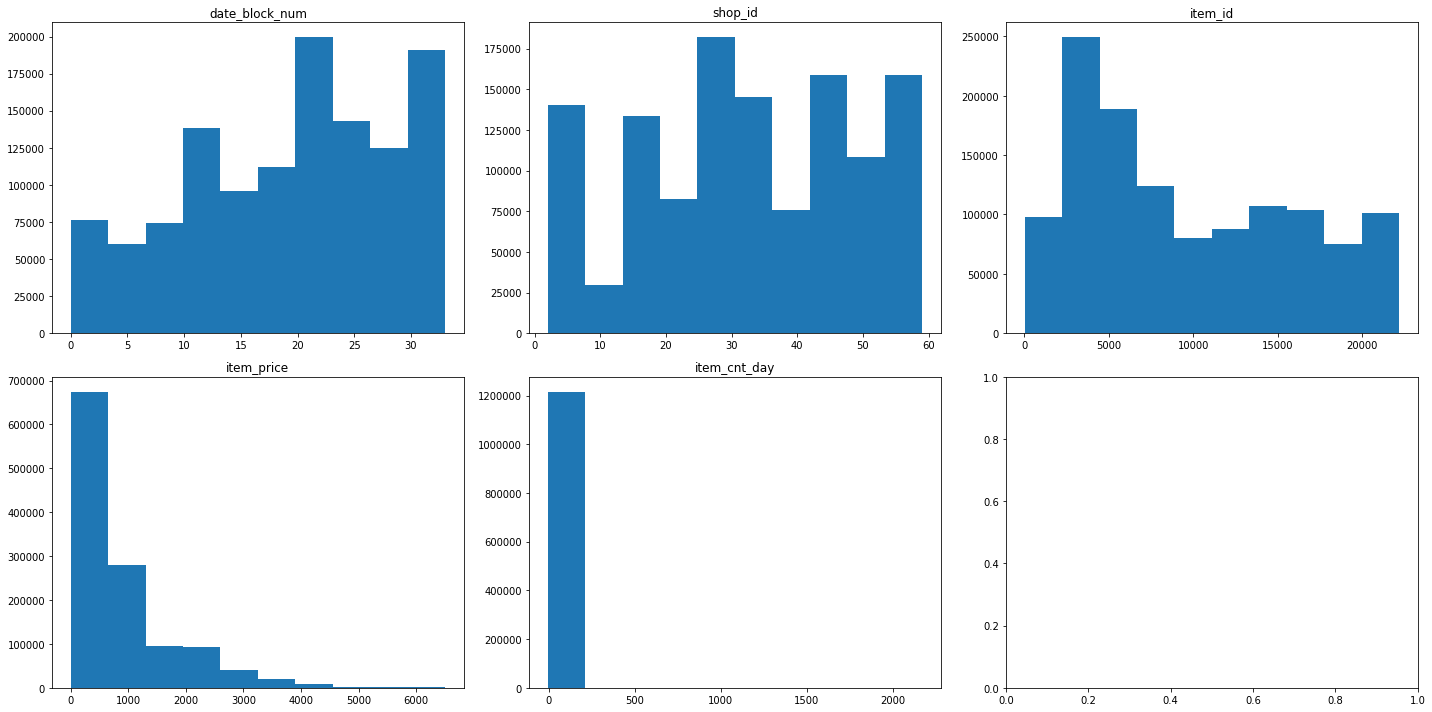

In [29]:
# check distribution of values

fig, axes = plt.subplots(2,3,figsize=(20,10))
axes[0, 0].hist(train['date_block_num'])
axes[0, 0].set_title('date_block_num')
plt.tight_layout()

axes[0, 1].hist(train['shop_id'])
axes[0, 1].set_title('shop_id')
plt.tight_layout()

axes[0, 2].hist(train['item_id'])
axes[0, 2].set_title('item_id')
plt.tight_layout()

axes[1, 0].hist(train['item_price'])
axes[1, 0].set_title('item_price')
plt.tight_layout()

axes[1, 1].hist(train['item_cnt_day'])
axes[1, 1].set_title('item_cnt_day')
plt.tight_layout()

In [30]:
# check shop names

shops

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


[Text(0,0.5,'frequency'), Text(0.5,0,'shop id')]

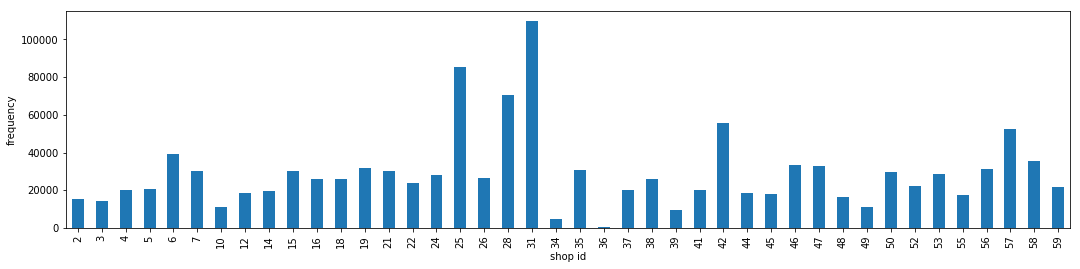

In [31]:
# check number of occurences for each shop
train.groupby("shop_id").item_id.count().plot(kind="bar", figsize=(18,4)).set(ylabel="frequency", xlabel="shop id")

In [32]:
# There are several duplicates in the shops. Remove them so that there is only one id per shop
# Take the id of the shop name version that is more common (see bars above)
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57

train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58

train.loc[train.shop_id == 11, 'shop_id'] = 10
test.loc[test.shop_id == 11, 'shop_id'] = 10

[Text(0,0.5,'frequency'), Text(0.5,0,'city')]

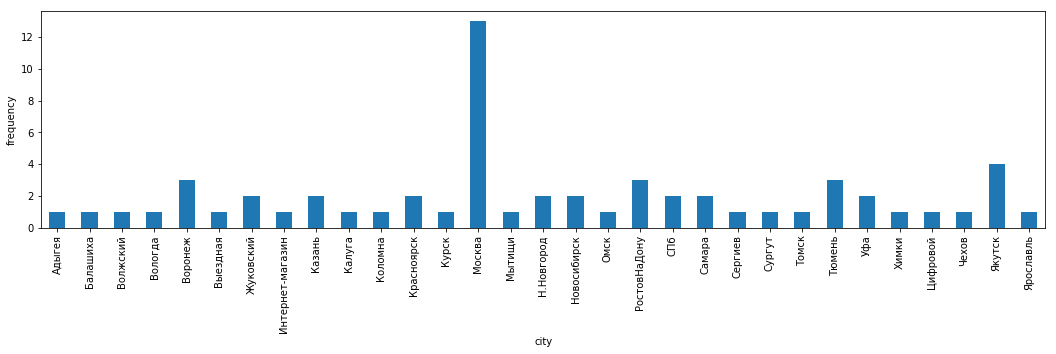

In [33]:
# it seems that the first part in the shop name refers to the city name
def get_city(x):
    return(x.split(' ', 1)[0])

shops['city']=shops['shop_name'].apply(get_city)
# there is one dubplicate where the city name is just spelled differently
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'

shops.groupby("city").city.count().plot(kind="bar", figsize=(18,4)).set(ylabel="frequency", xlabel="city")

In [34]:
# label-encode cities
le = preprocessing.LabelEncoder()
shops['city'] = le.fit_transform(shops['city'])

In [35]:
# inspect item categories

pd.set_option('display.max_rows', item_categories.shape[0]+1)
print(item_categories)

                          item_category_name  item_category_id
0                    PC - Гарнитуры/Наушники                 0
1                           Аксессуары - PS2                 1
2                           Аксессуары - PS3                 2
3                           Аксессуары - PS4                 3
4                           Аксессуары - PSP                 4
5                        Аксессуары - PSVita                 5
6                      Аксессуары - XBOX 360                 6
7                      Аксессуары - XBOX ONE                 7
8                             Билеты (Цифра)                 8
9                            Доставка товара                 9
10                     Игровые консоли - PS2                10
11                     Игровые консоли - PS3                11
12                     Игровые консоли - PS4                12
13                     Игровые консоли - PSP                13
14                  Игровые консоли - PSVita           

In [36]:
# for most of the items, the word before the '-' belongs to the general class and the word after to the subclass

item_categories['item_class'] = 'nan'
item_categories['item_subclass'] = 'nan'

for item_category_name, item_category_id, item_class, item_specific in item_categories.itertuples(index=False):
    
    if '-' in item_category_name:
        item_categories.loc[item_categories.item_category_id == item_category_id, 'item_class'] = item_category_name.split('-', 1)[0]
        item_categories.loc[item_categories.item_category_id == item_category_id, 'item_subclass'] = item_category_name.split('-', 1)[1]
        
    else:
        item_categories.loc[item_categories.item_category_id == item_category_id, 'item_class'] = item_category_name
        item_categories.loc[item_categories.item_category_id == item_category_id, 'item_subclass'] = item_category_name
        
# label-encode item classes
le = preprocessing.LabelEncoder()
item_categories['item_class'] = le.fit_transform(item_categories['item_class'])

le = preprocessing.LabelEncoder()
item_categories['item_subclass'] = le.fit_transform(item_categories['item_subclass'])

In [37]:
item_categories

,item_category_name,item_category_id,item_class,item_subclass
0,PC - Гарнитуры/Наушники,0,0,30
1,Аксессуары - PS2,1,1,11
2,Аксессуары - PS3,2,1,12
3,Аксессуары - PS4,3,1,13
4,Аксессуары - PSP,4,1,15
5,Аксессуары - PSVita,5,1,16
6,Аксессуары - XBOX 360,6,1,18
7,Аксессуары - XBOX ONE,7,1,19
8,Билеты (Цифра),8,2,60
9,Доставка товара,9,3,61


In [38]:
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [39]:
items_with_class_subclass = pd.merge(items, item_categories[['item_category_id', 'item_class', 'item_subclass']], on=['item_category_id'], how='left')
items_with_class_subclass

,item_name,item_id,item_category_id,item_class,item_subclass
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,11,6
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,15,32
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,11,6
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,11,6
4,***КОРОБКА (СТЕКЛО) D,4,40,11,6
...,...,...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31,8,59
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54,12,59
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49,12,38
22168,Яйцо для Little Inu,22168,62,14,29


## EDA + Feature Engineering

In [40]:
# create "revenue" column
train['revenue'] = train['item_price'] *  train['item_cnt_day']

# compute the revenue per date for each shop, we will use this later

grouped_date_shop_revenue = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
grouped_date_shop_revenue.columns = ['date_shop_revenue']
grouped_date_shop_revenue.reset_index(inplace=True)
grouped_date_shop_revenue

,date_block_num,shop_id,date_shop_revenue
0,0,2,2.034168e+05
1,0,3,1.374045e+05
2,0,4,3.283816e+05
3,0,6,6.328574e+05
4,0,7,4.128689e+05
...,...,...,...
1322,33,55,1.291565e+06
1323,33,56,1.088983e+06
1324,33,57,1.912463e+06
1325,33,58,1.399816e+06


In [41]:
# compute average item price and average item price per month

grouped_avg_item_price = train.groupby(['item_id']).agg({'item_price': ['mean']})
grouped_avg_item_price.columns = ['item_avg_item_price']
grouped_avg_item_price.reset_index(inplace=True)

grouped_date_avg_item_price = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
grouped_date_avg_item_price.columns = ['date_item_avg_item_price']
grouped_date_avg_item_price.reset_index(inplace=True)

In [42]:
# transform data to show item count per *month*

# create a grid with all possible combinations between shop and item ids

grid = []
for iblock in train['date_block_num'].unique():
    cur_shops = train[train.date_block_num==iblock].shop_id.unique()
    cur_items = train[train.date_block_num==iblock].item_id.unique()
    grid.append(np.array(list(product(*[[iblock], cur_shops, cur_items])),dtype='int32'))
index_cols = ['date_block_num', 'shop_id', 'item_id']
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# convert item_cnt_days column to count items per month
train_agg = train.groupby(['date_block_num', 'shop_id', 'item_id']) \
              .agg({'item_cnt_day':'sum', 'item_price':'mean'}) \
              .reset_index() \
              .rename(columns = {'item_cnt_day' : 'item_cnt_month'})

# transform to be in 0-20 range
train_agg['item_cnt_month'] = train_agg['item_cnt_month'].clip(0, 20)

# merge aggregated data into grid
train = pd.merge(grid,train_agg,how='left',on=index_cols)

# sort
train = train.sort_values(['date_block_num', 'shop_id', 'item_id'], ascending=True)

train['item_cnt_month'] = train['item_cnt_month'].fillna(0)

In [43]:
# merge item and shop information onto training and test data
train = pd.merge(train, items_with_class_subclass[['item_id', 'item_class', 'item_subclass']], on=['item_id'], how='left')
test = pd.merge(test, items_with_class_subclass[['item_id', 'item_class', 'item_subclass']], on=['item_id'], how='left')

train = pd.merge(train, shops[['shop_id', 'city']], on=['shop_id'], how='left')
test = pd.merge(test, shops[['shop_id', 'city']], on=['shop_id'], how='left')

In [44]:
# only select items and shops that are present in the test set

shop_ids_test = test['shop_id'].unique()
item_ids_test = test['item_id'].unique()
cities_test = test['city'].unique()

# Only shops that exist in test set
train = train[train['shop_id'].isin(shop_ids_test)]
# Only items that exist in test set
train = train[train['item_id'].isin(item_ids_test)]

len(train)

2717777

In [45]:
# add year and month
train['year'] = 0
train.loc[train.date_block_num<13, 'year']=2013
train.loc[(train.date_block_num>12) & (train.date_block_num<25), 'year']=2014
train.loc[(train.date_block_num>24), 'year']=2015

train['month'] = train['date_block_num'] % 12

test['date_block_num'] = 34
test=test.drop('ID', axis=1)
test['year'] = 10
test['month'] = 10

In [46]:
# merge train and test

train_test = pd.concat([train, test], ignore_index=True, sort=False, keys=['date_block_num','shop_id','item_id'])
#train_test.fillna(0, inplace=True) # 34 month

train_test

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_class,item_subclass,city,year,month
0,0,2,32,0.0,NaN,11,6,0,2013,0
1,0,2,33,1.0,499.0,11,1,0,2013,0
2,0,2,42,0.0,NaN,13,10,0,2013,0
3,0,2,45,0.0,NaN,13,10,0,2013,0
4,0,2,51,0.0,NaN,13,10,0,2013,0
...,...,...,...,...,...,...,...,...,...,...
2931972,34,45,18454,NaN,NaN,13,4,20,10,10
2931973,34,45,16188,NaN,NaN,14,41,20,10,10
2931974,34,45,15757,NaN,NaN,13,4,20,10,10
2931975,34,45,19648,NaN,NaN,11,6,20,10,10


[Text(0,0.5,'mean item price'), Text(0.5,0,'city id')]

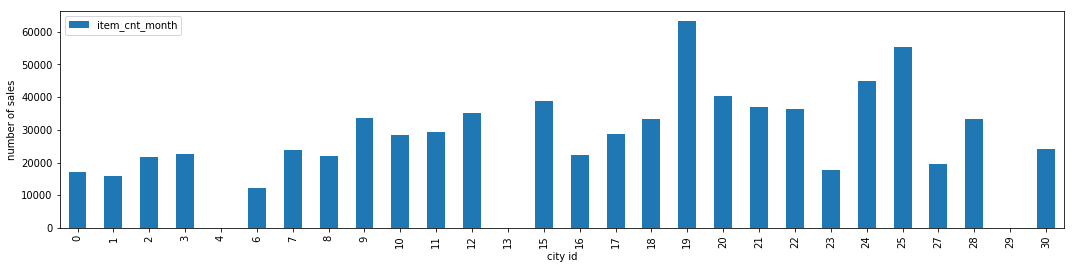

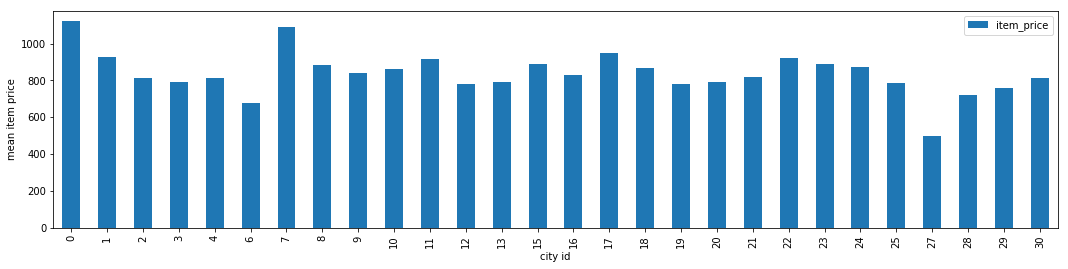

In [47]:
train.groupby(['city']).agg({'item_cnt_month':'sum'}).plot(kind="bar", figsize=(18,4)).set(ylabel="number of sales", xlabel="city id")
train.groupby(['city']).agg({'item_price':'mean'}).plot(kind="bar", figsize=(18,4)).set(ylabel="mean item price", xlabel="city id")

[Text(0,0.5,'mean number of sales'), Text(0.5,0,'date_num_block')]

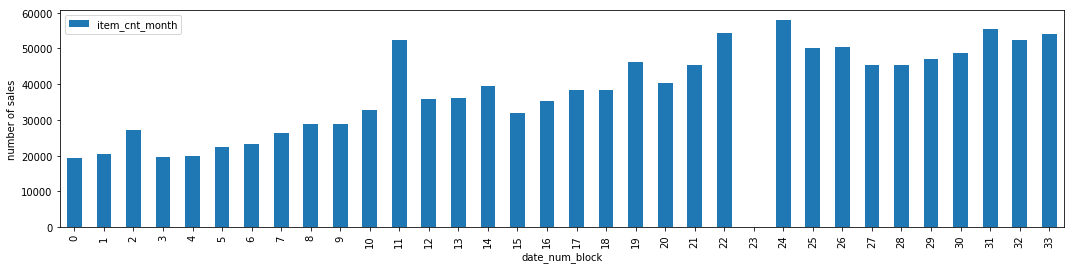

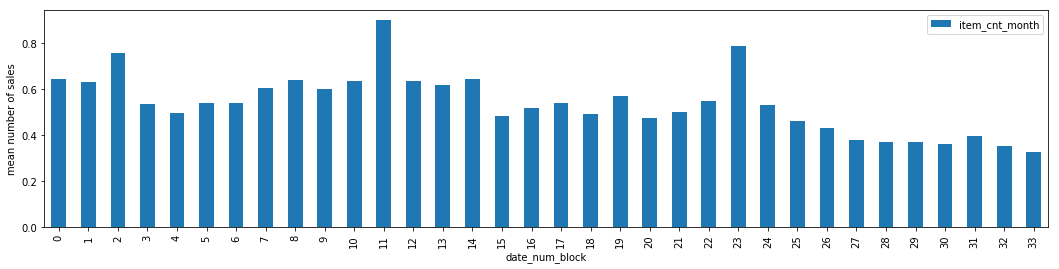

In [48]:
# From this plot it seems that there is one month with a lot of sales (December porbably Christmas sales)

train.groupby(['date_block_num']).agg({'item_cnt_month':'sum'}).plot(kind="bar", figsize=(18,4)).set(ylabel="number of sales", xlabel="date_num_block")
train.groupby(['date_block_num']).agg({'item_cnt_month':'mean'}).plot(kind="bar", figsize=(18,4)).set(ylabel="mean number of sales", xlabel="date_num_block")

[Text(0,0.5,'mean number of sales per year'), Text(0.5,0,'year')]

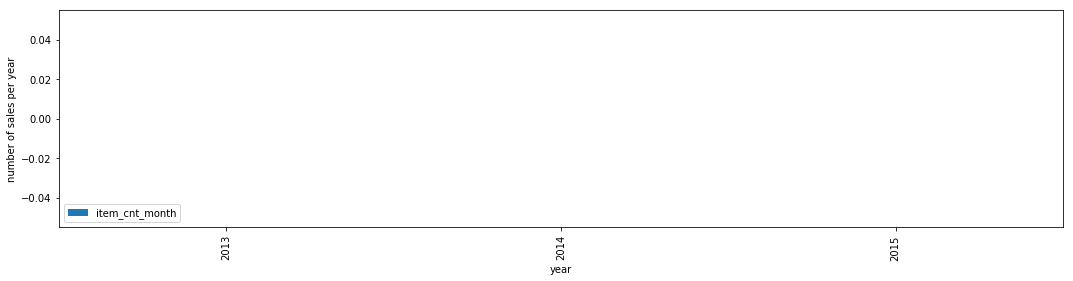

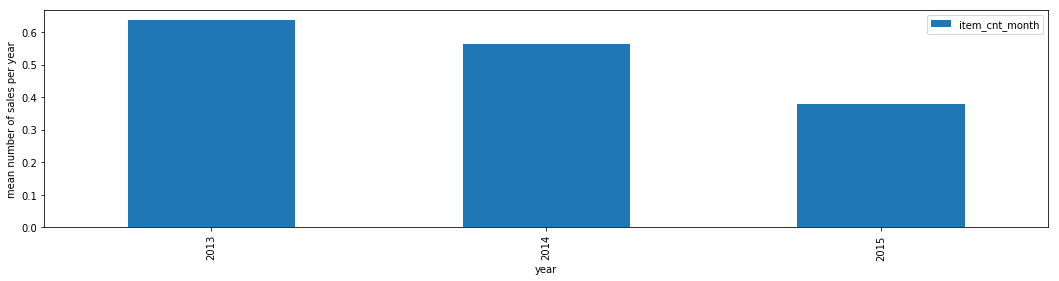

In [49]:
train.groupby(['year']).agg({'item_cnt_month':'sum'}).plot(kind="bar", figsize=(18,4)).set(ylabel="number of sales per year", xlabel="year")
train.groupby(['year']).agg({'item_cnt_month':'mean'}).plot(kind="bar", figsize=(18,4)).set(ylabel="mean number of sales per year", xlabel="year")

[Text(0,0.5,'mean number of sales per month'), Text(0.5,0,'month')]

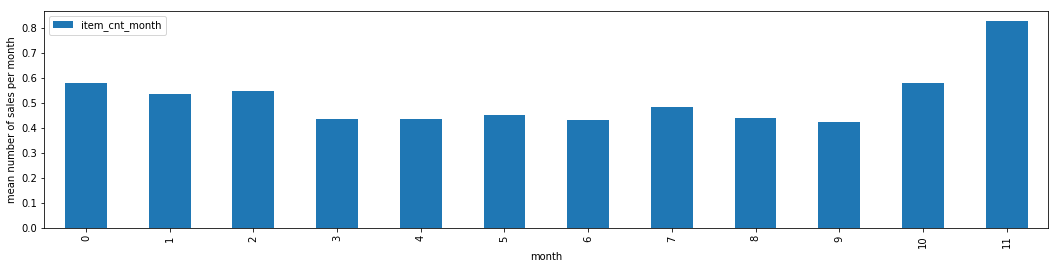

In [50]:
train.groupby(['month']).agg({'item_cnt_month':'mean'}).plot(kind="bar", figsize=(18,4)).set(ylabel="mean number of sales per month", xlabel="month")

[Text(0,0.5,'number of holidays'), Text(0.5,0,'month')]

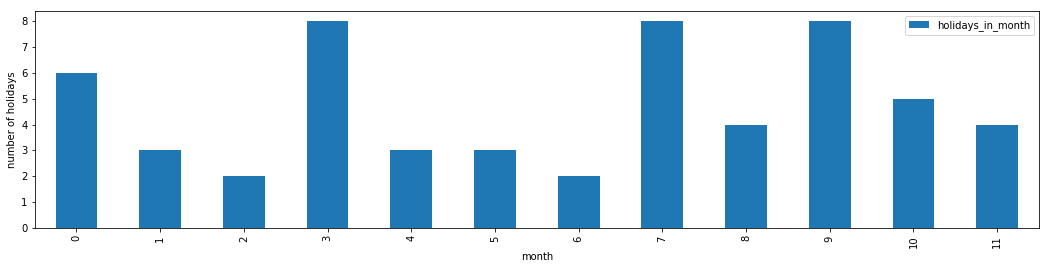

In [51]:
holiday_dict = {
    0: 6,
    1: 3,
    2: 2,
    3: 8,
    4: 3,
    5: 3,
    6: 2,
    7: 8,
    8: 4,
    9: 8,
    10: 5,
    11: 4,
}


train['holidays_in_month'] = train['month'].map(holiday_dict)
train.groupby(['month']).agg({'holidays_in_month':'mean'}).plot(kind="bar", figsize=(18,4)).set(ylabel="number of holidays", xlabel="month")

Text(0.5,1,'Test set')

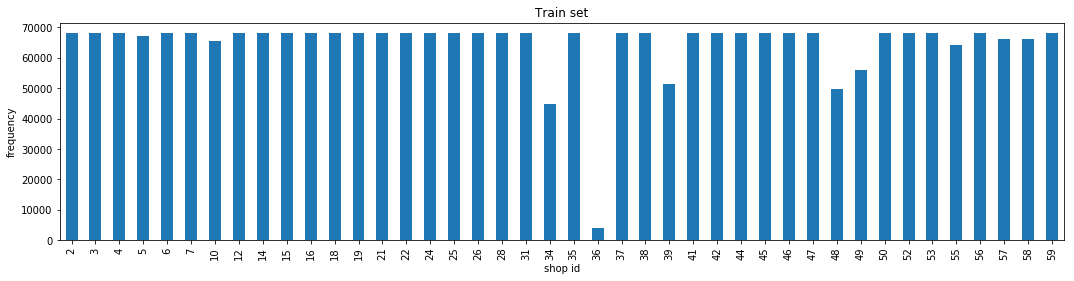

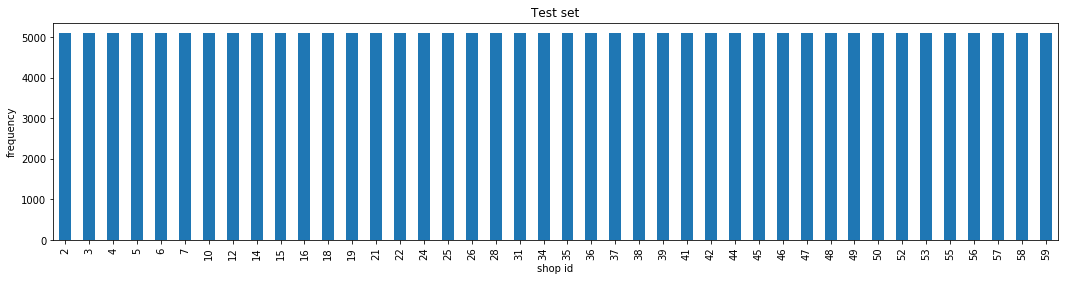

In [52]:
# compare frequencies of shops in train and test set
# there are some shops that are in the train but not the test set and vice versa

fig1, ax1 = plt.subplots()
train.groupby("shop_id").item_id.count().plot(kind="bar", figsize=(18,4)).set(ylabel="frequency", xlabel="shop id")
ax1.set_title("Train set")

fig2, ax2 = plt.subplots()
test.groupby("shop_id").item_id.count().plot(kind="bar", figsize=(18,4)).set(ylabel="frequency", xlabel="shop id")
ax2.set_title("Test set")

Text(0.5,1,'Test set')

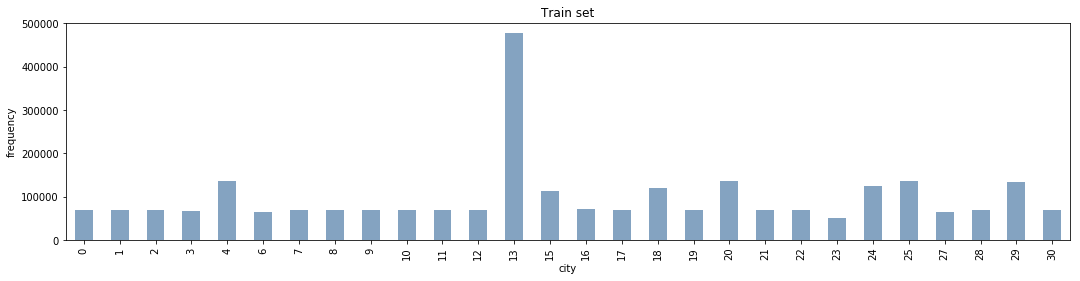

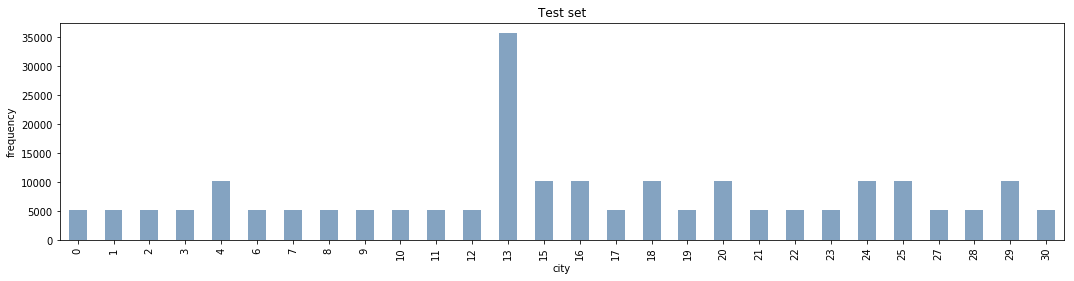

In [53]:
# compare frequencies of cities in train and test set
# there are some cities that are in the train but not the test set and vice versa

fig1, ax1 = plt.subplots()
train.groupby("city").item_id.count().plot(kind="bar", figsize=(18,4), color=(0.2, 0.4, 0.6, 0.6)).set(ylabel="frequency", xlabel="city")
ax1.set_title("Train set")

fig2, ax2 = plt.subplots()
test.groupby("city").item_id.count().plot(kind="bar", figsize=(18,4), color=(0.2, 0.4, 0.6, 0.6)).set(ylabel="frequency", xlabel="city")
ax2.set_title("Test set")

In [54]:
# item price per unit

train_test['item_price_unit'] = train_test['item_price'] // train_test['item_cnt_month']

In [55]:
# mean, min/max price, price range

grouped = train_test.groupby('item_id').agg({'item_price_unit':'mean'})
grouped.columns = ['item_mean_price']
grouped.reset_index(inplace=True)

train_test = pd.merge(train_test, grouped, on=['item_id'], how='left')

In [56]:
pd.set_option('display.max_columns', 500)
train_test

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_class,item_subclass,city,year,month,item_price_unit,item_mean_price
0,0,2,32,0.0,NaN,11,6,0,2013,0,NaN,inf
1,0,2,33,1.0,499.0,11,1,0,2013,0,499.0,inf
2,0,2,42,0.0,NaN,13,10,0,2013,0,NaN,250.120000
3,0,2,45,0.0,NaN,13,10,0,2013,0,NaN,265.747573
4,0,2,51,0.0,NaN,13,10,0,2013,0,NaN,235.744186
...,...,...,...,...,...,...,...,...,...,...,...,...
2931972,34,45,18454,NaN,NaN,13,4,20,10,10,NaN,114.153465
2931973,34,45,16188,NaN,NaN,14,41,20,10,10,NaN,1256.750000
2931974,34,45,15757,NaN,NaN,13,4,20,10,10,NaN,189.528517
2931975,34,45,19648,NaN,NaN,11,6,20,10,10,NaN,85.973684


In [57]:
#train_test_new = train_test.copy()

In [58]:
# add some lag-features

# lags = [1,2,3,6,12]
lags = [1,2,3,4,5,6]

def generate_lag(df, lags, column):
    for lag in lags:
        df_shift = df[['date_block_num', 'shop_id', 'item_id', column]].copy()
        df_shift.columns = ['date_block_num', 'shop_id', 'item_id', column +'_lag_'+ str(lag)]
        df_shift['date_block_num'] += lag
        df = pd.merge(df, df_shift, on=['date_block_num', 'shop_id', 'item_id'], how='left')
    return df

In [59]:
train_test

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_class,item_subclass,city,year,month,item_price_unit,item_mean_price
0,0,2,32,0.0,NaN,11,6,0,2013,0,NaN,inf
1,0,2,33,1.0,499.0,11,1,0,2013,0,499.0,inf
2,0,2,42,0.0,NaN,13,10,0,2013,0,NaN,250.120000
3,0,2,45,0.0,NaN,13,10,0,2013,0,NaN,265.747573
4,0,2,51,0.0,NaN,13,10,0,2013,0,NaN,235.744186
...,...,...,...,...,...,...,...,...,...,...,...,...
2931972,34,45,18454,NaN,NaN,13,4,20,10,10,NaN,114.153465
2931973,34,45,16188,NaN,NaN,14,41,20,10,10,NaN,1256.750000
2931974,34,45,15757,NaN,NaN,13,4,20,10,10,NaN,189.528517
2931975,34,45,19648,NaN,NaN,11,6,20,10,10,NaN,85.973684


In [60]:
# number of sells in nth previous month

train_test = generate_lag(train_test, lags, 'item_cnt_month')

In [61]:
# average number of sells in nth previous month 

grouped = train_test.groupby(['date_block_num']).agg({'item_cnt_month':'mean'})
grouped.columns = ['avg_item_cnt_per_month']
grouped.reset_index(inplace=True)

train_test = pd.merge(train_test, grouped, on=['date_block_num'], how='left')
train_test['avg_item_cnt_per_month'] = train_test['avg_item_cnt_per_month'].astype(np.float16)
train_test = generate_lag(train_test, lags, 'avg_item_cnt_per_month')
train_test.drop(['avg_item_cnt_per_month'], axis=1, inplace=True)

In [62]:
# mean number of sells for given item in nth previous month

grouped = train_test.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month':'mean'})
grouped.columns = ['avg_item_cnt_per_item_month']
grouped.reset_index(inplace=True)

train_test = pd.merge(train_test, grouped, on=['date_block_num','item_id'], how='left')
train_test['avg_item_cnt_per_item_month'] = train_test['avg_item_cnt_per_item_month'].astype(np.float16)
train_test = generate_lag(train_test, lags, 'avg_item_cnt_per_item_month')
train_test.drop(['avg_item_cnt_per_item_month'], axis=1, inplace=True)

In [63]:
# mean number of sells for given item in nth previous month

grouped = train_test.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month':'mean'})
grouped.columns = ['avg_item_cnt_per_shop_month']
grouped.reset_index(inplace=True)

train_test = pd.merge(train_test, grouped, on=['date_block_num','shop_id'], how='left')
train_test['avg_item_cnt_per_shop_month'] = train_test['avg_item_cnt_per_shop_month'].astype(np.float16)
train_test = generate_lag(train_test, lags, 'avg_item_cnt_per_shop_month')
train_test.drop(['avg_item_cnt_per_shop_month'], axis=1, inplace=True)

In [64]:
# mean number of sells for given shop in nth previous month

grouped = train_test.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_month':'mean'})
grouped.columns = ['avg_item_cnt_per_item_shop_month']
grouped.reset_index(inplace=True)

train_test = pd.merge(train_test, grouped, on=['date_block_num','shop_id', 'item_id'], how='left')
train_test['avg_item_cnt_per_item_shop_month'] = train_test['avg_item_cnt_per_item_shop_month'].astype(np.float16)
train_test = generate_lag(train_test, lags, 'avg_item_cnt_per_item_shop_month')
train_test.drop(['avg_item_cnt_per_item_shop_month'], axis=1, inplace=True)

In [65]:
# mean number of sells for given shop in nth previous month

grouped = train_test.groupby(['date_block_num', 'shop_id', 'item_class']).agg({'item_cnt_month':'mean'})
grouped.columns = ['avg_item_cnt_per_item_class_shop_month']
grouped.reset_index(inplace=True)

train_test = pd.merge(train_test, grouped, on=['date_block_num','shop_id', 'item_class'], how='left')
train_test['avg_item_cnt_per_item_class_shop_month'] = train_test['avg_item_cnt_per_item_class_shop_month'].astype(np.float16)
train_test = generate_lag(train_test, lags, 'avg_item_cnt_per_item_class_shop_month')
train_test.drop(['avg_item_cnt_per_item_class_shop_month'], axis=1, inplace=True)

In [66]:
# mean number of sells for given shop in nth previous month

grouped = train_test.groupby(['date_block_num', 'shop_id', 'item_subclass']).agg({'item_cnt_month':'mean'})
grouped.columns = ['avg_item_cnt_per_item_subclass_shop_month']
grouped.reset_index(inplace=True)

train_test = pd.merge(train_test, grouped, on=['date_block_num','shop_id', 'item_subclass'], how='left')
train_test['avg_item_cnt_per_item_subclass_shop_month'] = train_test['avg_item_cnt_per_item_subclass_shop_month'].astype(np.float16)
train_test = generate_lag(train_test, lags, 'avg_item_cnt_per_item_subclass_shop_month')
train_test.drop(['avg_item_cnt_per_item_subclass_shop_month'], axis=1, inplace=True)

In [67]:
# mean number of sells for given item class in nth previous month

grouped = train_test.groupby(['date_block_num', 'item_class']).agg({'item_cnt_month':'mean'})
grouped.columns = ['avg_item_cnt_per_item_class_month']
grouped.reset_index(inplace=True)

train_test = pd.merge(train_test, grouped, on=['date_block_num','item_class'], how='left')
train_test['avg_item_cnt_per_item_class_month'] = train_test['avg_item_cnt_per_item_class_month'].astype(np.float16)
train_test = generate_lag(train_test, lags, 'avg_item_cnt_per_item_class_month')
train_test.drop(['avg_item_cnt_per_item_class_month'], axis=1, inplace=True)

In [68]:
# mean number of sells for given item subclass in nth previous month

grouped = train_test.groupby(['date_block_num', 'item_subclass']).agg({'item_cnt_month':'mean'})
grouped.columns = ['avg_item_cnt_per_item_subclass_month']
grouped.reset_index(inplace=True)

train_test = pd.merge(train_test, grouped, on=['date_block_num','item_subclass'], how='left')
train_test['avg_item_cnt_per_item_subclass_month'] = train_test['avg_item_cnt_per_item_subclass_month'].astype(np.float16)
train_test = generate_lag(train_test, lags, 'avg_item_cnt_per_item_subclass_month')
train_test.drop(['avg_item_cnt_per_item_subclass_month'], axis=1, inplace=True)

In [69]:
# mean number of sells for given city in nth previous month

grouped = train_test.groupby(['date_block_num', 'city']).agg({'item_cnt_month':'mean'})
grouped.columns = ['avg_item_cnt_per_city_month']
grouped.reset_index(inplace=True)

train_test = pd.merge(train_test, grouped, on=['date_block_num','city'], how='left')
train_test['avg_item_cnt_per_city_month'] = train_test['avg_item_cnt_per_city_month'].astype(np.float16)
train_test = generate_lag(train_test, lags, 'avg_item_cnt_per_city_month')
train_test.drop(['avg_item_cnt_per_city_month'], axis=1, inplace=True)

In [70]:
# mean number of sells for given item in given shop in nth previous month

grouped = train_test.groupby(['date_block_num', 'item_id', 'shop_id']).agg({'item_cnt_month':'mean'})
grouped.columns = ['avg_item_cnt_per_item_in_shop_month']
grouped.reset_index(inplace=True)

train_test = pd.merge(train_test, grouped, on=['date_block_num', 'item_id', 'shop_id'], how='left')
train_test['avg_item_cnt_per_item_in_shop_month'] = train_test['avg_item_cnt_per_item_in_shop_month'].astype(np.float16)
train_test = generate_lag(train_test, lags, 'avg_item_cnt_per_item_in_shop_month')
train_test.drop(['avg_item_cnt_per_item_in_shop_month'], axis=1, inplace=True)

In [71]:
# mean number of sells for given item in given city in nth previous month

grouped = train_test.groupby(['date_block_num', 'item_id', 'city']).agg({'item_cnt_month':'mean'})
grouped.columns = ['avg_item_cnt_per_item_in_city_month']
grouped.reset_index(inplace=True)

train_test = pd.merge(train_test, grouped, on=['date_block_num', 'item_id', 'city'], how='left')
train_test['avg_item_cnt_per_item_in_city_month'] = train_test['avg_item_cnt_per_item_in_city_month'].astype(np.float16)
train_test = generate_lag(train_test, lags, 'avg_item_cnt_per_item_in_city_month')
train_test.drop(['avg_item_cnt_per_item_in_city_month'], axis=1, inplace=True)

In [72]:
# mean item price in nth previous month

grouped = train_test.groupby(['item_id', 'date_block_num']).agg({'item_price_unit':'mean'})
grouped.columns = ['avg_item_price_per_month']
grouped.reset_index(inplace=True)

train_test = pd.merge(train_test, grouped, on=['date_block_num', 'item_id'], how='left')
train_test['avg_item_price_per_month'] = train_test['avg_item_price_per_month'].astype(np.float16)
train_test = generate_lag(train_test, lags, 'avg_item_price_per_month')
train_test.drop(['avg_item_price_per_month'], axis=1, inplace=True)

In [73]:
# mean item price in given shop in nth previous month

grouped = train_test.groupby(['item_id', 'date_block_num', 'shop_id']).agg({'item_price_unit':'mean'})
grouped.columns = ['avg_item_price_per_shop_per_month']
grouped.reset_index(inplace=True)

train_test = pd.merge(train_test, grouped, on=['date_block_num', 'item_id', 'shop_id'], how='left')
train_test['avg_item_price_per_shop_per_month'] = train_test['avg_item_price_per_shop_per_month'].astype(np.float16)
train_test = generate_lag(train_test, lags, 'avg_item_price_per_shop_per_month')
train_test.drop(['avg_item_price_per_shop_per_month'], axis=1, inplace=True)

In [74]:
train_test

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_class,item_subclass,city,year,month,item_price_unit,item_mean_price,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,avg_item_cnt_per_month_lag_1,avg_item_cnt_per_month_lag_2,avg_item_cnt_per_month_lag_3,avg_item_cnt_per_month_lag_4,avg_item_cnt_per_month_lag_5,avg_item_cnt_per_month_lag_6,avg_item_cnt_per_item_month_lag_1,avg_item_cnt_per_item_month_lag_2,avg_item_cnt_per_item_month_lag_3,avg_item_cnt_per_item_month_lag_4,avg_item_cnt_per_item_month_lag_5,avg_item_cnt_per_item_month_lag_6,avg_item_cnt_per_shop_month_lag_1,avg_item_cnt_per_shop_month_lag_2,avg_item_cnt_per_shop_month_lag_3,avg_item_cnt_per_shop_month_lag_4,avg_item_cnt_per_shop_month_lag_5,avg_item_cnt_per_shop_month_lag_6,avg_item_cnt_per_item_shop_month_lag_1,avg_item_cnt_per_item_shop_month_lag_2,avg_item_cnt_per_item_shop_month_lag_3,avg_item_cnt_per_item_shop_month_lag_4,avg_item_cnt_per_item_shop_month_lag_5,avg_item_cnt_per_item_shop_month_lag_6,avg_item_cnt_per_item_class_shop_month_lag_1,avg_item_cnt_per_item_class_shop_month_lag_2,avg_item_cnt_per_item_class_shop_month_lag_3,avg_item_cnt_per_item_class_shop_month_lag_4,avg_item_cnt_per_item_class_shop_month_lag_5,avg_item_cnt_per_item_class_shop_month_lag_6,avg_item_cnt_per_item_subclass_shop_month_lag_1,avg_item_cnt_per_item_subclass_shop_month_lag_2,avg_item_cnt_per_item_subclass_shop_month_lag_3,avg_item_cnt_per_item_subclass_shop_month_lag_4,avg_item_cnt_per_item_subclass_shop_month_lag_5,avg_item_cnt_per_item_subclass_shop_month_lag_6,avg_item_cnt_per_item_class_month_lag_1,avg_item_cnt_per_item_class_month_lag_2,avg_item_cnt_per_item_class_month_lag_3,avg_item_cnt_per_item_class_month_lag_4,avg_item_cnt_per_item_class_month_lag_5,avg_item_cnt_per_item_class_month_lag_6,avg_item_cnt_per_item_subclass_month_lag_1,avg_item_cnt_per_item_subclass_month_lag_2,avg_item_cnt_per_item_subclass_month_lag_3,avg_item_cnt_per_item_subclass_month_lag_4,avg_item_cnt_per_item_subclass_month_lag_5,avg_item_cnt_per_item_subclass_month_lag_6,avg_item_cnt_per_city_month_lag_1,avg_item_cnt_per_city_month_lag_2,avg_item_cnt_per_city_month_lag_3,avg_item_cnt_per_city_month_lag_4,avg_item_cnt_per_city_month_lag_5,avg_item_cnt_per_city_month_lag_6,avg_item_cnt_per_item_in_shop_month_lag_1,avg_item_cnt_per_item_in_shop_month_lag_2,avg_item_cnt_per_item_in_shop_month_lag_3,avg_item_cnt_per_item_in_shop_month_lag_4,avg_item_cnt_per_item_in_shop_month_lag_5,avg_item_cnt_per_item_in_shop_month_lag_6,avg_item_cnt_per_item_in_city_month_lag_1,avg_item_cnt_per_item_in_city_month_lag_2,avg_item_cnt_per_item_in_city_month_lag_3,avg_item_cnt_per_item_in_city_month_lag_4,avg_item_cnt_per_item_in_city_month_lag_5,avg_item_cnt_per_item_in_city_month_lag_6,avg_item_price_per_month_lag_1,avg_item_price_per_month_lag_2,avg_item_price_per_month_lag_3,avg_item_price_per_month_lag_4,avg_item_price_per_month_lag_5,avg_item_price_per_month_lag_6,avg_item_price_per_shop_per_month_lag_1,avg_item_price_per_shop_per_month_lag_2,avg_item_price_per_shop_per_month_lag_3,avg_item_price_per_shop_per_month_lag_4,avg_item_price_per_shop_per_month_lag_5,avg_item_price_per_shop_per_month_lag_6
0,0,2,32,0.0,NaN,11,6,0,2013,0,NaN,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,33,1.0,499.0,11,1,0,2013,0,499.0,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [75]:
grouped_avg_item_price

,item_id,item_avg_item_price
0,30,324.562531
1,31,573.793091
2,32,250.083710
3,33,249.273010
4,38,2351.537109
...,...,...
4669,22162,384.521576
4670,22163,165.735138
4671,22164,713.923218
4672,22166,150.000000


In [76]:
### add trend in shop revenue

# merge shop revenue onto data matrix
train_test = pd.merge(train_test, grouped_date_shop_revenue, on=['date_block_num','shop_id'], how='left')
train_test['date_shop_revenue'] = train_test['date_shop_revenue'].astype(np.float32)

# compute mean item price by item_id
grouped = grouped_date_shop_revenue.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
grouped.columns = ['avg_shop_revenue']
grouped.reset_index(inplace=True)

train_test = pd.merge(train_test, grouped, on=['shop_id'], how='left')
train_test['avg_shop_revenue'] = train_test['avg_shop_revenue'].astype(np.float32)

train_test['trend_revenue'] = (train_test['date_shop_revenue'] - train_test['avg_shop_revenue']) / train_test['avg_shop_revenue']
train_test['trend_revenue'] = train_test['trend_revenue'].astype(np.float16)


train_test = generate_lag(train_test, [1, 2, 3, 6], 'trend_revenue')
train_test.drop(['date_shop_revenue','avg_shop_revenue','trend_revenue'], axis=1, inplace=True)
train_test


,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_class,item_subclass,city,year,month,item_price_unit,item_mean_price,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,avg_item_cnt_per_month_lag_1,avg_item_cnt_per_month_lag_2,avg_item_cnt_per_month_lag_3,avg_item_cnt_per_month_lag_4,avg_item_cnt_per_month_lag_5,avg_item_cnt_per_month_lag_6,avg_item_cnt_per_item_month_lag_1,avg_item_cnt_per_item_month_lag_2,avg_item_cnt_per_item_month_lag_3,avg_item_cnt_per_item_month_lag_4,avg_item_cnt_per_item_month_lag_5,avg_item_cnt_per_item_month_lag_6,avg_item_cnt_per_shop_month_lag_1,avg_item_cnt_per_shop_month_lag_2,avg_item_cnt_per_shop_month_lag_3,avg_item_cnt_per_shop_month_lag_4,avg_item_cnt_per_shop_month_lag_5,avg_item_cnt_per_shop_month_lag_6,avg_item_cnt_per_item_shop_month_lag_1,avg_item_cnt_per_item_shop_month_lag_2,avg_item_cnt_per_item_shop_month_lag_3,avg_item_cnt_per_item_shop_month_lag_4,avg_item_cnt_per_item_shop_month_lag_5,avg_item_cnt_per_item_shop_month_lag_6,avg_item_cnt_per_item_class_shop_month_lag_1,avg_item_cnt_per_item_class_shop_month_lag_2,avg_item_cnt_per_item_class_shop_month_lag_3,avg_item_cnt_per_item_class_shop_month_lag_4,avg_item_cnt_per_item_class_shop_month_lag_5,avg_item_cnt_per_item_class_shop_month_lag_6,avg_item_cnt_per_item_subclass_shop_month_lag_1,avg_item_cnt_per_item_subclass_shop_month_lag_2,avg_item_cnt_per_item_subclass_shop_month_lag_3,avg_item_cnt_per_item_subclass_shop_month_lag_4,avg_item_cnt_per_item_subclass_shop_month_lag_5,avg_item_cnt_per_item_subclass_shop_month_lag_6,avg_item_cnt_per_item_class_month_lag_1,avg_item_cnt_per_item_class_month_lag_2,avg_item_cnt_per_item_class_month_lag_3,avg_item_cnt_per_item_class_month_lag_4,avg_item_cnt_per_item_class_month_lag_5,avg_item_cnt_per_item_class_month_lag_6,avg_item_cnt_per_item_subclass_month_lag_1,avg_item_cnt_per_item_subclass_month_lag_2,avg_item_cnt_per_item_subclass_month_lag_3,avg_item_cnt_per_item_subclass_month_lag_4,avg_item_cnt_per_item_subclass_month_lag_5,avg_item_cnt_per_item_subclass_month_lag_6,avg_item_cnt_per_city_month_lag_1,avg_item_cnt_per_city_month_lag_2,avg_item_cnt_per_city_month_lag_3,avg_item_cnt_per_city_month_lag_4,avg_item_cnt_per_city_month_lag_5,avg_item_cnt_per_city_month_lag_6,avg_item_cnt_per_item_in_shop_month_lag_1,avg_item_cnt_per_item_in_shop_month_lag_2,avg_item_cnt_per_item_in_shop_month_lag_3,avg_item_cnt_per_item_in_shop_month_lag_4,avg_item_cnt_per_item_in_shop_month_lag_5,avg_item_cnt_per_item_in_shop_month_lag_6,avg_item_cnt_per_item_in_city_month_lag_1,avg_item_cnt_per_item_in_city_month_lag_2,avg_item_cnt_per_item_in_city_month_lag_3,avg_item_cnt_per_item_in_city_month_lag_4,avg_item_cnt_per_item_in_city_month_lag_5,avg_item_cnt_per_item_in_city_month_lag_6,avg_item_price_per_month_lag_1,avg_item_price_per_month_lag_2,avg_item_price_per_month_lag_3,avg_item_price_per_month_lag_4,avg_item_price_per_month_lag_5,avg_item_price_per_month_lag_6,avg_item_price_per_shop_per_month_lag_1,avg_item_price_per_shop_per_month_lag_2,avg_item_price_per_shop_per_month_lag_3,avg_item_price_per_shop_per_month_lag_4,avg_item_price_per_shop_per_month_lag_5,avg_item_price_per_shop_per_month_lag_6,trend_revenue_lag_1,trend_revenue_lag_2,trend_revenue_lag_3,trend_revenue_lag_6
0,0,2,32,0.0,NaN,11,6,0,2013,0,NaN,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,33,1.0,499.0,11,1,0,2013,0,499.0,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [77]:
# number of days in each month
map_days = {0:31, 1:28, 2:31, 3:30, 4:31, 5:30, 6:31, 7:31, 8:30, 9:31, 10:30, 11:31}
train_test['days'] = train_test['month'].map(map_days).astype(np.int8)

In [78]:
train_test.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_class,item_subclass,city,year,month,item_price_unit,item_mean_price,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,avg_item_cnt_per_month_lag_1,avg_item_cnt_per_month_lag_2,avg_item_cnt_per_month_lag_3,avg_item_cnt_per_month_lag_4,avg_item_cnt_per_month_lag_5,avg_item_cnt_per_month_lag_6,avg_item_cnt_per_item_month_lag_1,avg_item_cnt_per_item_month_lag_2,avg_item_cnt_per_item_month_lag_3,avg_item_cnt_per_item_month_lag_4,avg_item_cnt_per_item_month_lag_5,avg_item_cnt_per_item_month_lag_6,avg_item_cnt_per_shop_month_lag_1,avg_item_cnt_per_shop_month_lag_2,avg_item_cnt_per_shop_month_lag_3,avg_item_cnt_per_shop_month_lag_4,avg_item_cnt_per_shop_month_lag_5,avg_item_cnt_per_shop_month_lag_6,avg_item_cnt_per_item_shop_month_lag_1,avg_item_cnt_per_item_shop_month_lag_2,avg_item_cnt_per_item_shop_month_lag_3,avg_item_cnt_per_item_shop_month_lag_4,avg_item_cnt_per_item_shop_month_lag_5,avg_item_cnt_per_item_shop_month_lag_6,avg_item_cnt_per_item_class_shop_month_lag_1,avg_item_cnt_per_item_class_shop_month_lag_2,avg_item_cnt_per_item_class_shop_month_lag_3,avg_item_cnt_per_item_class_shop_month_lag_4,avg_item_cnt_per_item_class_shop_month_lag_5,avg_item_cnt_per_item_class_shop_month_lag_6,avg_item_cnt_per_item_subclass_shop_month_lag_1,avg_item_cnt_per_item_subclass_shop_month_lag_2,avg_item_cnt_per_item_subclass_shop_month_lag_3,avg_item_cnt_per_item_subclass_shop_month_lag_4,avg_item_cnt_per_item_subclass_shop_month_lag_5,avg_item_cnt_per_item_subclass_shop_month_lag_6,avg_item_cnt_per_item_class_month_lag_1,avg_item_cnt_per_item_class_month_lag_2,avg_item_cnt_per_item_class_month_lag_3,avg_item_cnt_per_item_class_month_lag_4,avg_item_cnt_per_item_class_month_lag_5,avg_item_cnt_per_item_class_month_lag_6,avg_item_cnt_per_item_subclass_month_lag_1,avg_item_cnt_per_item_subclass_month_lag_2,avg_item_cnt_per_item_subclass_month_lag_3,avg_item_cnt_per_item_subclass_month_lag_4,avg_item_cnt_per_item_subclass_month_lag_5,avg_item_cnt_per_item_subclass_month_lag_6,avg_item_cnt_per_city_month_lag_1,avg_item_cnt_per_city_month_lag_2,avg_item_cnt_per_city_month_lag_3,avg_item_cnt_per_city_month_lag_4,avg_item_cnt_per_city_month_lag_5,avg_item_cnt_per_city_month_lag_6,avg_item_cnt_per_item_in_shop_month_lag_1,avg_item_cnt_per_item_in_shop_month_lag_2,avg_item_cnt_per_item_in_shop_month_lag_3,avg_item_cnt_per_item_in_shop_month_lag_4,avg_item_cnt_per_item_in_shop_month_lag_5,avg_item_cnt_per_item_in_shop_month_lag_6,avg_item_cnt_per_item_in_city_month_lag_1,avg_item_cnt_per_item_in_city_month_lag_2,avg_item_cnt_per_item_in_city_month_lag_3,avg_item_cnt_per_item_in_city_month_lag_4,avg_item_cnt_per_item_in_city_month_lag_5,avg_item_cnt_per_item_in_city_month_lag_6,avg_item_price_per_month_lag_1,avg_item_price_per_month_lag_2,avg_item_price_per_month_lag_3,avg_item_price_per_month_lag_4,avg_item_price_per_month_lag_5,avg_item_price_per_month_lag_6,avg_item_price_per_shop_per_month_lag_1,avg_item_price_per_shop_per_month_lag_2,avg_item_price_per_shop_per_month_lag_3,avg_item_price_per_shop_per_month_lag_4,avg_item_price_per_shop_per_month_lag_5,avg_item_price_per_shop_per_month_lag_6,trend_revenue_lag_1,trend_revenue_lag_2,trend_revenue_lag_3,trend_revenue_lag_6,days
0,0,2,32,0.0,NaN,11,6,0,2013,0,NaN,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31
1,0,2,33,1.0,499.0,11,1,0,2013,0,499.0,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [79]:
### Add special features when the item was first sold and last sold

In [80]:
ts = time.time()
cache = {}
train_test['last_sale_item_shop'] = -1
train_test['last_sale_item_shop'] = train_test['last_sale_item_shop'].astype(np.int8)
for idx, row in train_test.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        train_test.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num
time.time() - ts


1150.3938810825348

In [81]:
ts = time.time()
cache = {}
train_test['last_sale_item'] = -1
train_test['last_sale_item'] = train_test['last_sale_item'].astype(np.int8)
for idx, row in train_test.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            train_test.at[idx, 'last_sale_item'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         
time.time() - ts


833.6355366706848

In [82]:
ts = time.time()
train_test['time_from_first_sale_item'] = train_test['date_block_num'] - train_test.groupby('item_id')['date_block_num'].transform('min')
train_test['time_from_first_sale_item_shop'] = train_test['date_block_num'] - train_test.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
time.time() - ts

3.7681970596313477

In [ ]:
train_test.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_class,item_subclass,city,year,month,item_price_unit,item_mean_price,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,avg_item_cnt_per_month_lag_1,avg_item_cnt_per_month_lag_2,avg_item_cnt_per_month_lag_3,avg_item_cnt_per_month_lag_4,avg_item_cnt_per_month_lag_5,avg_item_cnt_per_month_lag_6,avg_item_cnt_per_item_month_lag_1,avg_item_cnt_per_item_month_lag_2,avg_item_cnt_per_item_month_lag_3,avg_item_cnt_per_item_month_lag_4,avg_item_cnt_per_item_month_lag_5,avg_item_cnt_per_item_month_lag_6,avg_item_cnt_per_shop_month_lag_1,avg_item_cnt_per_shop_month_lag_2,avg_item_cnt_per_shop_month_lag_3,avg_item_cnt_per_shop_month_lag_4,avg_item_cnt_per_shop_month_lag_5,avg_item_cnt_per_shop_month_lag_6,avg_item_cnt_per_item_shop_month_lag_1,avg_item_cnt_per_item_shop_month_lag_2,avg_item_cnt_per_item_shop_month_lag_3,avg_item_cnt_per_item_shop_month_lag_4,avg_item_cnt_per_item_shop_month_lag_5,avg_item_cnt_per_item_shop_month_lag_6,avg_item_cnt_per_item_class_shop_month_lag_1,avg_item_cnt_per_item_class_shop_month_lag_2,avg_item_cnt_per_item_class_shop_month_lag_3,avg_item_cnt_per_item_class_shop_month_lag_4,avg_item_cnt_per_item_class_shop_month_lag_5,avg_item_cnt_per_item_class_shop_month_lag_6,avg_item_cnt_per_item_subclass_shop_month_lag_1,avg_item_cnt_per_item_subclass_shop_month_lag_2,avg_item_cnt_per_item_subclass_shop_month_lag_3,avg_item_cnt_per_item_subclass_shop_month_lag_4,avg_item_cnt_per_item_subclass_shop_month_lag_5,avg_item_cnt_per_item_subclass_shop_month_lag_6,avg_item_cnt_per_item_class_month_lag_1,avg_item_cnt_per_item_class_month_lag_2,avg_item_cnt_per_item_class_month_lag_3,avg_item_cnt_per_item_class_month_lag_4,avg_item_cnt_per_item_class_month_lag_5,avg_item_cnt_per_item_class_month_lag_6,avg_item_cnt_per_item_subclass_month_lag_1,avg_item_cnt_per_item_subclass_month_lag_2,avg_item_cnt_per_item_subclass_month_lag_3,avg_item_cnt_per_item_subclass_month_lag_4,avg_item_cnt_per_item_subclass_month_lag_5,avg_item_cnt_per_item_subclass_month_lag_6,avg_item_cnt_per_city_month_lag_1,avg_item_cnt_per_city_month_lag_2,avg_item_cnt_per_city_month_lag_3,avg_item_cnt_per_city_month_lag_4,avg_item_cnt_per_city_month_lag_5,avg_item_cnt_per_city_month_lag_6,avg_item_cnt_per_item_in_shop_month_lag_1,avg_item_cnt_per_item_in_shop_month_lag_2,avg_item_cnt_per_item_in_shop_month_lag_3,avg_item_cnt_per_item_in_shop_month_lag_4,avg_item_cnt_per_item_in_shop_month_lag_5,avg_item_cnt_per_item_in_shop_month_lag_6,avg_item_cnt_per_item_in_city_month_lag_1,avg_item_cnt_per_item_in_city_month_lag_2,avg_item_cnt_per_item_in_city_month_lag_3,avg_item_cnt_per_item_in_city_month_lag_4,avg_item_cnt_per_item_in_city_month_lag_5,avg_item_cnt_per_item_in_city_month_lag_6,avg_item_price_per_month_lag_1,avg_item_price_per_month_lag_2,avg_item_price_per_month_lag_3,avg_item_price_per_month_lag_4,avg_item_price_per_month_lag_5,avg_item_price_per_month_lag_6,avg_item_price_per_shop_per_month_lag_1,avg_item_price_per_shop_per_month_lag_2,avg_item_price_per_shop_per_month_lag_3,avg_item_price_per_shop_per_month_lag_4,avg_item_price_per_shop_per_month_lag_5,avg_item_price_per_shop_per_month_lag_6,trend_revenue_lag_1,trend_revenue_lag_2,trend_revenue_lag_3,trend_revenue_lag_6,days,last_sale_item_shop,item_shop_last_sale,last_sale_item,time_from_first_sale_item,time_from_first_sale_item_shop
0,0,2,32,0.0,NaN,11,6,0,2013,0,NaN,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31,-1,NaN,-1,0,0
1,0,2,33,1.0,499.0,11,1,0,2013,0,499.0,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

## Train model

### Define train and validation set

In [ ]:
# some columns have to be dropped since they were used only to create new features but are
# not present in the testing data themselves

columns_drop = ['item_price', 'item_price_unit', 'item_mean_price']
train_test.drop(columns_drop, axis=1, inplace=True)

In [ ]:
X_train = train_test[train_test.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = train_test[train_test.date_block_num < 33]['item_cnt_month']
X_valid = train_test[train_test.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = train_test[train_test.date_block_num == 33]['item_cnt_month']
X_test = train_test[train_test.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [ ]:
X_train.head()

In [ ]:
X_test.head()

### XGBoost

In [ ]:
### Parameter tuning for XGBoost

'''

xgb = XGBRegressor()

parameters = {'objective': 'regression',
             'metric':'rmse',
             'boosting':'gbdt',
             'learning_rate': [.01, .02, .03, .05, .07, .1, .2]),
             'n_estimators': hp.choice('n_estimators', [100, 200, 500, 1000, 3000]),
             'min_child_weight': hp.choice('min_child_weight', [10, 20, 30, 40, 100, 300, 500]),
             'subsample': hp.choice('subsample', [.7, .8, .85, .9, .95, 1]),
             'colsample_bytree': hp.choice('colsample_bytree', [.5, .6, .7, .8, .9, .95, 1]),
             'max_depth':  hp.choice('max_depth', [3, 5, 6, 8, 10, 12, 15]),
             'alpha': hp.choice('alpha', [.04, 0.7, .1, .2, .3, .4, .5, .6, .7]),
             'lambda':  hp.choice('lambda', [.04, .07, .1, .2, .3, .4, .5, .6])}

xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

'''

In [ ]:
ts = time.time()

model_xgb = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model_xgb.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

# rmse score:
# validation_0-rmse:1.1027	validation_1-rmse:0.92228 only select items and shops that are present in the test set

In [ ]:
from xgboost import plot_importance

fig, ax = plt.subplots(1,1,figsize=(10,15))
plot_importance(booster=model_xgb, ax=ax)

### Lightgbm

In [ ]:
### Parameter tuning for Lightgbm

'''

# Define searched space
hyper_space_lgbm = {'objective': 'regression',
                   'metric':'rmse',
                   'boosting':'gbdt',
                   'n_estimators': hp.choice('n_estimators', [50, 100, 200, 500]),
                   'learning_rate': hp.choice('learning_rate', [.01, .02, .03, .1, .2]),
                   'num_leaves': hp.choice('num_leaves', [25, 32, 50, 75, 100, 125, 150, 225, 250, 350]),
                   'colsample_bytree': hp.choice('colsample_bytree', [.5, .6, .7, .8, .9, .95, 1]),
                   'subsample': hp.choice('subsample', [.7, .8, .85, .9, .95, 1]),
                   'max_depth':  hp.choice('max_depth', [3, 5, 8, 10, 12, 15]),
                   'reg_alpha': hp.choice('reg_alpha', [.04, 0.7, .1, .2, .3, .4, .5, .6, .7]),
                   'reg_lambda':  hp.choice('reg_lambda', [.04, .07, .1, .2, .3, .4, .5, .6]), 
                   'feature_fraction':  hp.choice('feature_fraction', [.6, .7, .8, .9, 1]), 
                   'bagging_frequency':  hp.choice('bagging_frequency', [.3, .4, .5, .6, .7, .8, .9]),
                   'min_split_gain': hp.choice('min_split_gain', [.01, .02, .05]),
                   'min_child_weight': hp.choice('min_child_weight', [10, 20, 30, 40])}

lgtrain = lightgbm.Dataset(X_train, label=Y_train)
lgval = lightgbm.Dataset(X_valid, label=Y_valid)

def evaluate_metric(params):
    
    model_lgb = lightgbm.train(params, lgtrain, 600, 
                          valid_sets=[lgtrain, lgval], early_stopping_rounds=100, 
                          verbose_eval=300)

    pred = model_lgb.predict(X_valid, num_iteration=1000)
    
    score = rmse(pred, Y_valid)
    
    print(score, params)
 
    return {
        'loss': score,
        'status': STATUS_OK,
        'stats_running': STATUS_RUNNING
    }

def rmse(y_pred, y):
    return np.sqrt(np.mean(np.square(y - y_pred)))

# Trail
trials = Trials()

# Set algorithm parameters
algo = partial(tpe.suggest, 
               n_startup_jobs=-1)

# Seting the number of Evals
MAX_EVALS= 30

# Fit Tree Parzen Estimator
best_vals = fmin(evaluate_metric, space=hyper_space_lgbm, verbose=1,
                 algo=algo, max_evals=MAX_EVALS, trials=trials)

# Print best parameters
best_params_lgbm = space_eval(hyper_space_lgbm, best_vals)

print("BEST PARAMETERS: " + str(best_params_lgbm))

'''

In [ ]:
ts = time.time()

model_lgbm = LGBMRegressor(
    objective = 'regression',
    metric = 'rmse',
    boosting = 'gbdt',
    max_depth = 10,
    num_leaves = 150,
    subsample = 0.7,
    colsample_bytree = 0.5,
    learning_rate = 0.03,
    nestimators=200,
    reg_alpha = 0.5,
    reg_lambda = 0.07, 
    # 'bagging_fraction': hp.choice('bagging_fraction', [.5, .6, .7, .8, .9, 1]),
    feature_fraction = 0.7, 
    bagging_frequency= 0.4,                  
    min_child_samples = 20,
    min_split_gain = 0.05
)

model_lgbm.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

### Combine predictions

In [ ]:
Y_valid_pred_xgb = model_xgb.predict(X_valid).clip(0, 20)
Y_test_pred_xgb = model_xgb.predict(X_test).clip(0, 20)

Y_valid_pred_lgbm = model_lgbm.predict(X_valid).clip(0, 20)
Y_test_pred_lgbm = model_lgbm.predict(X_test).clip(0, 20)

In [ ]:
Y_test_pred_all = Y_test_pred_xgb / 2
Y_test_pred_all += Y_test_pred_lgbm / 2

## Create submission

In [ ]:
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test_pred_all
})
submission.to_csv('submission.csv', index=False)